In [0]:
# Execute this cell to install OpenMM in the Colab environment
!pip install -q openmm

# Building Systems from Scratch

## Introduction

The previous two tutorials in this series showed how to use OpenMM to set up simulations using existing inputs: either molecular structures along with predefined force fields, or parameterized input files for other molecular dynamics engines like Amber or CHARMM.  We also saw how to use the OpenMM Setup tool to automatically generate Python scripts to run OpenMM for cases like these.  This way of using OpenMM is most useful for setting up simulations of biomolecules, for example, and uses OpenMM's convenient [application layer](https://docs.openmm.org/latest/api-python/app.html) for assigning parameters to complex topologies.  However, for simpler systems, *e.g.*, Lennard-Jones fluid mixtures, model colloidal crystals, bead-spring polymers, or other simple coarse-grained models, you might not need the complexity of this layer, and may also prefer more control over how your simulation is set up.  Alternatively, you might want to inspect or modify the OpenMM System objects created by one of the methods discussed in the previous tutorials, or write your own library for building simulations.  For these use cases, you can work directly with OpenMM's [library layer](https://docs.openmm.org/latest/api-python/library.html).

This tutorial shows how to use the library layer to build [System](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.System.html) objects.  Since OpenMM Setup is geared towards generating scripts using predefined structures or force fields, we will not use it here.  Instead, we will show how to write a script from scratch to set up and run a simulation of a binary Lennard-Jones fluid mixture.  In particular, we will simulate a mixture of particles of two types, "A" and "B", with pairwise interactions governed by the Lennard-Jones potential, $$u_{ij}(r)=4\epsilon_{ij}\left(\frac{\sigma_{ij}^{12}}{r^{12}}-\frac{\sigma_{ij}^6}{r^6}\right),$$  where $\sigma_{ij}$ and $\epsilon_{ij}$ for a pair of particle types are given from parameters $\sigma_i$ and $\epsilon_i$ for each particle type by the Lorentz-Berthelot mixing rules $\sigma_{ij}=(\sigma_i+\sigma_j)/2$ and $\epsilon_{ij}=\sqrt{\epsilon_i\epsilon_j}$.

## Writing the Script

To get started, we will import OpenMM:

In [1]:
import openmm
import openmm.app
import openmm.unit

For this tutorial, we will use classes within their packages rather than importing all of them into the global scope like the OpenMM Setup-generated scripts do.

We will also import some other packages that are not strictly necessary for interacting with OpenMM but will be useful for the tutorial:

In [2]:
import matplotlib.pyplot as plt
import numpy as np

### Dimensionless Units

We have seen in the previous tutorials that OpenMM uses a [default unit system](https://docs.openmm.org/latest/userguide/theory/01_introduction.html#units) with $\mathrm{nm}$ for length, $\mathrm{kJ/mol}$ for energy, $\mathrm{ps}$ for time, *etc.*, but also provides a [units API](https://docs.openmm.org/latest/api-python/app.html#units) for [manipulating and converting between](https://docs.openmm.org/latest/userguide/library/05_languages_not_cpp.html#units-and-dimensional-analysis) units.  On the other hand, it is common in theoretical work, as well as simulation studies of simple model systems like Lennard-Jones fluids, to specify values of parameters relative to some fixed scales, *e.g.*, a length scale $\sigma$, an energy scale $\epsilon$, a time scale $\tau$, *etc.*, rather than concrete units.  It is often convenient to omit these scales entirely and write, *e.g.*, a parameter like a density $\rho=0.6\sigma^{-3}$ in dimensionless form $\rho^*=0.6$.  As long as a self-consistent set of reference scales is chosen, dimensionless values can be used throughout a calculation.

Some care must be taken in order to do this in OpenMM.  Passing unitless values to OpenMM when it expects quantities with units causes them to be interpreted in its default unit system, whose length, energy, time, and mass ($\mathrm{g/mol}$) scales are all consistent with each other, but whose temperature ($\mathrm{K}$) and pressure ($\mathrm{bar}$) scales are not.  Thus, it is better to still use OpenMM's units API, and explicitly define the scale factors needed to obtain a consistent set of units.  For length, mass, energy, and time, we can use the default units:

In [3]:
length_scale = openmm.unit.nanometer
mass_scale = openmm.unit.dalton
energy_scale = openmm.unit.kilojoule_per_mole
time_scale = openmm.unit.picosecond

(One may note that these cannot all be independent, but it turns out that $1\ \mathrm{kJ/mol}=1\ (\mathrm{g/mol})(\mathrm{nm}^2/\mathrm{ps}^2)$, so this set of units works.)  For pressure, we want an energy per volume, but if we try this with our current set of scales, OpenMM will not let the result be converted to other pressure units:

In [4]:
(1.0 * energy_scale / length_scale ** 3).in_units_of(openmm.unit.bar)

TypeError: Unit "kilojoule/(nanometer**3*mole)" is not compatible with Unit "bar".

The problem is the factor of $\mathrm{1/mol}$ in the energy scale, which OpenMM will not automatically eliminate.  Since a mole is just a fixed quantity of something, we can divide by the constant `AVOGADRO_CONSTANT_NA` that OpenMM provides to remove this factor and obtain a pressure scale consistent with the other scales we have defined.

In [5]:
press_scale = energy_scale / (length_scale ** 3 * openmm.unit.AVOGADRO_CONSTANT_NA)

This quantity can now be converted to $\mathrm{bar}$:

In [6]:
press_scale.in_units_of(openmm.unit.bar)

16.60539067173847 bar

Similarly, from an energy scale, we can get a temperature scale by dividing by Boltzmann's constant, which OpenMM provides as `BOLTZMANN_CONSTANT_kB`.  We must again also divide by the Avogadro constant to remove a factor of $\mathrm{1/mol}$ from the energy scale:

In [7]:
temp_scale = energy_scale / (openmm.unit.BOLTZMANN_CONSTANT_kB * openmm.unit.AVOGADRO_CONSTANT_NA)

In $\mathrm{K}$, this is:

In [8]:
temp_scale.in_units_of(openmm.unit.kelvin)

120.27235504272605 K

### Simulation Parameters

With all of these scale factors in place, we can now define the actual parameters for our simulation.  First, we set values for the number of particles of each type, a starting number density for the system, and particle masses:

In [9]:
N_A = 500
N_B = 500

rho = 0.6 / length_scale ** 3

m_A = 1.0 * mass_scale
m_B = 1.1 * mass_scale

These are all ordinary variables; OpenMM will not do anything special with them until we explicitly provide them, as we will show below.

Next, we set some Lennard-Jones potential parameters.  We also define a cutoff distance $r_{\mathrm{cut}}$ beyond which the potential will not be evaluated.

In [10]:
r_cut = 3.0 * length_scale

sigma_A = 1.0 * length_scale
sigma_B = 1.2 * length_scale

epsilon_A = 1.0 * energy_scale
epsilon_B = 1.3 * energy_scale

Finally, we define a pressure and temperature for the system, and thermostat parameters that will be used later:

In [11]:
press = 2.0 * press_scale
temp = 1.5 * temp_scale
friction = 1.0 / time_scale
step = 0.005 * time_scale

### Creating the System

We are now ready to set up the simulation proper.  In OpenMM, this begins with a [System](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.System.html), which instead of generating from a ForceField or other input data as was done in the previous tutorials, we now create directly:

In [12]:
system = openmm.System()

A System object stores basic information about particles in a system, such as their masses, any rigid constraints between particles, and any definitions of [virtual sites](https://docs.openmm.org/latest/userguide/theory/05_other_features.html#virtual-sites) (particles whose positions are computed based on positions of other particles, rather than integrated normally).  Details of the *interactions* between the particles are not stored directly in the System, but instead, inside of [Forces](https://docs.openmm.org/latest/api-python/library.html#forces) added to the System.

We begin by setting the default size of the periodic box on the System with [System.setDefaultPeriodicBoxVectors()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.System.html#openmm.openmm.System.setDefaultPeriodicBoxVectors).  We will later add a barostat to control the pressure, so the box will be scaled during simulation, but as discussed in [the previous tutorial](loading_and_reporting.ipynb#Input-Files), OpenMM needs default vectors to set up a Context.  Here, we create a cubic box giving the specified initial number density `rho`:

In [13]:
L_box = ((N_A + N_B) / rho) ** (1 / 3)
system.setDefaultPeriodicBoxVectors(openmm.Vec3(L_box, 0, 0), openmm.Vec3(0, L_box, 0), openmm.Vec3(0, 0, L_box))

Note here that we use OpenMM's built-in [Vec3](https://docs.openmm.org/latest/api-python/generated/openmm.vec3.Vec3.html) class, which represents 3-dimensional vectors and can perform basic mathematical operations on them.  However, OpenMM functions that accept Vec3 instances can also accept other sequences like lists, tuples, or NumPy arrays.

We now add particles to the System one by one with [System.addParticle()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.System.html#openmm.openmm.System.addParticle).  An OpenMM System has no direct concept of "particle types".  Instead, you can create the particles in any order you want, as long as you ensure that particle parameters set in Forces are ordered in the same way.  Here, we will treat the first `N_A` particles in the System as type A, and the next `N_B` particles as type B.

In [14]:
for i_A in range(N_A):
    system.addParticle(m_A)
for i_B in range(N_B):
    system.addParticle(m_B)

addParticle() returns the index of the particle just added to the System, so if you wanted to add particles in a less obvious order, and keep track of the indices of particles of each type, for instance, OpenMM makes it easy to do so.

Now we need to define the interactions between particles.  We want to apply a Lennard-Jones potential between particle pairs, with Lorentz-Berthelot mixing rules.  We could use any function of interparticle distances as a pair potential, since OpenMM provides a [CustomNonbondedForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomNonbondedForce.html) that accepts arbitrary mathematical expressions as strings and compiles them into optimized kernels for computation.  However, the potential we want here is so common in simulations that OpenMM provides a built-in class, [NonbondedForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.NonbondedForce.html), to handle it:

In [15]:
lj = openmm.NonbondedForce()

By default, newly created NonbondedForce objects are set to NoCutoff mode, which means that they ignore periodic boundary conditions and compute the potential for every pair of particles in a simulation.  To only compute interactions within a fixed cutoff, using the minimum image convention to apply periodic boundary conditions, use the `CutoffPeriodic` option to [NonbondedForce.setNonbondedMethod()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.NonbondedForce.html#openmm.openmm.NonbondedForce.setNonbondedMethod), and call [NonbondedForce.setCutoffDistance()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.NonbondedForce.html#openmm.openmm.NonbondedForce.setCutoffDistance) to set the cutoff distance.

In [16]:
lj.setNonbondedMethod(openmm.NonbondedForce.CutoffPeriodic)
lj.setCutoffDistance(r_cut)

The [theory section of the user guide](https://docs.openmm.org/latest/userguide/theory/02_standard_forces.html#lennard-jones-interaction) discusses a number of other options for computing these as well as Coulomb interactions with NonbondedForce.

Next, we register particle parameters with the NonbondedForce.  We must call [NonbondedForce.addParticle()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.NonbondedForce.html#openmm.openmm.NonbondedForce.addParticle) for each particle in the System that we want to add the NonbondedForce to; each subsequent call sets parameters for each particle in the System in order.  Consistent with the order we added the particles to the System, then, we set Lennard-Jones parameters for every A particle first, followed by every B particle:

In [17]:
for i_A in range(N_A):
    lj.addParticle(0.0, sigma_A, epsilon_A)
for i_B in range(N_B):
    lj.addParticle(0.0, sigma_B, epsilon_B)

The first parameter to addParticle() is the electric charge.  If all charges are set to zero, as above, no Coulomb interactions will be computed by the NonbondedForce.

Finally, to actually use our newly created NonbondedForce, we must add it to the System with [System.addForce()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.System.html#openmm.openmm.System.addForce):

In [18]:
system.addForce(lj);

As in previous tutorials, we add a MonteCarloBarostat to the System for pressure control, and use a LangevinMiddleIntegrator for integration and temperature control:

In [19]:
system.addForce(openmm.MonteCarloBarostat(press, temp))
integrator = openmm.LangevinMiddleIntegrator(temp, friction, step)

### Creating the Simulation

We have now prepared a System and an Integrator for our simulation.  Recall that in previous tutorials, we created a [Simulation](https://docs.openmm.org/latest/api-python/generated/openmm.app.simulation.Simulation.html) object from a System and an Integrator, but also provided a [Topology](https://docs.openmm.org/latest/api-python/generated/openmm.app.topology.Topology.html) that was loaded from our input files.  Since we have already set all of the parameters for our simulation in the System, OpenMM does not need a Topology to assign parameters from a ForceField, but some of the [reporter classes](https://docs.openmm.org/latest/api-python/app.html#reporting-output) still require a Topology for output, so we will demonstrate how to build one from scratch.  This process starts with creating an empty Topology:

In [20]:
topology = openmm.app.Topology()

The information in a Topology is structured hierarchically, with each Topology containing a list of [Chain](https://docs.openmm.org/latest/api-python/generated/openmm.app.topology.Chain.html) objects, each Chain a list of [Residue](https://docs.openmm.org/latest/api-python/generated/openmm.app.topology.Residue.html) objects, and each Residue a list of [Atom](https://docs.openmm.org/latest/api-python/generated/openmm.app.topology.Atom.html) objects.  For simulations of biopolymers, the elements of this hierarchy map naturally onto the standard meanings of their terms in biochemistry.  For other kinds of simulations like this one, there may not be a natural correspondence, and so there is some flexibility in how we construct the Topology.  Note that once a System is fully built, OpenMM only uses the Topology for reporting outputs like PDB files using OpenMM's standard reporters.  Thus, defining a Topology with the same number of atoms in a custom-built System, but with a nonsensical hierarchy or connectivity, will actually make no difference when running the simulation.

For example, if we had a mixture of polyatomic molecules, we could create a Chain for each molecule, and either add all of the atoms in the molecule to one Residue in the Chain, or divide the atoms across several Residues if desired.  Alternatively, since there is no requirement that a Chain consist of a single connected molecule, we could assign one Residue per molecule and group molecules of each type into the a Chain for convenience.  We will take this latter approach here, and create Chain objects for each type of particle with [Topology.addChain()](https://docs.openmm.org/latest/api-python/generated/openmm.app.topology.Topology.html#openmm.app.topology.Topology.addChain):

In [21]:
chain_A = topology.addChain()
chain_B = topology.addChain()

We can add a Residue to an already created Chain with [Topology.addResidue()](https://docs.openmm.org/latest/api-python/generated/openmm.app.topology.Topology.html#openmm.app.topology.Topology.addResidue), providing a name to identify the Residue (which need not be unique).  Since this simulation uses single particles rather than polyatomic molecules, we add a single Atom to each Residue with [Topology.addAtom()](https://docs.openmm.org/latest/api-python/generated/openmm.app.topology.Topology.html#openmm.app.topology.Topology.addAtom).  In general, the name of each Atom should be unique within a Residue.  The Atoms should be added to the Topology in the same order that particles were added to the System.

In [22]:
for i_A in range(N_A):
    residue = topology.addResidue("A", chain_A)
    topology.addAtom("A", None, residue)
for i_B in range(N_B):
    residue = topology.addResidue("B", chain_B)
    topology.addAtom("B", None, residue)

The parameter to addAtom() set to `None` above specifies an optional chemical element for the Atom.  Since this is a model system, we do not set elements for the Atoms here, but OpenMM provides the [Element](https://docs.openmm.org/latest/api-python/generated/openmm.app.element.Element.html) class for use when appropriate.

Now that we have a Topology, we can create a [Simulation](https://docs.openmm.org/latest/api-python/generated/openmm.app.simulation.Simulation.html) object, just as in the previous tutorials.

In [23]:
simulation = openmm.app.Simulation(topology, system, integrator)

When we set up a simulation from a PDB file, input coordinates were already available.  When building a System and a Topology from scratch, you will need to provide your own initial coordinates.  You can read them from any file format of your choice or generate them *via* any method of your choice, before passing them to [Context.setPositions()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Context.html#openmm.openmm.Context.setPositions).  In this example, we will generate a simple [rock salt (B1) lattice](https://www.atomic-scale-physics.de/lattice/struk/b1.html) for the initial positions of our particles:

In [24]:
grid_a, grid_b = [], []

for i_x in range(10):
    for i_y in range(10):
        for i_z in range(10):
            (grid_a, grid_b)[(i_x + i_y + i_z) % 2].append(openmm.Vec3(i_x / 10, i_y / 10, i_z / 10) * L_box)

simulation.context.setPositions(grid_a + grid_b)

We can then minimize the energy of the initial configuration and set velocities:

In [25]:
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(temp)

### Running Dynamics

We are now ready to run simulation steps, just as we have done in the previous tutorials.

In [26]:
simulation.step(10000)

All of OpenMM's builtin reporters can be added to the Simulation as desired, as well as any custom reporters.  Here, we will instead calculate the radial distribution function (RDF) for each of the pairs of components in the mixture.  The details of the calculation are not germane to this tutorial, and the implementation here is not optimized.  As such, using an external library for such analysis is usually better, but the following illustrates a simple way to do this with NumPy alone.

In [27]:
# Define the edges of the bins on which to evaluate the RDFs.
rdf_bins = np.linspace(0.0, 4.0, 401)

# Make arrays in which to accumulate the RDFs.
rdf_aa = np.zeros(rdf_bins.size - 1)
rdf_bb = np.zeros(rdf_bins.size - 1)
rdf_ab = np.zeros(rdf_bins.size - 1)

# Track the number of accumulations we have done so far.
rdf_count = 0

def calculate_rdf(state):
    global rdf_aa, rdf_bb, rdf_ab, rdf_count

    # Extract the positions and box vectors from a State.
    positions = state.getPositions(asNumpy=True) / length_scale
    lengths = np.diag(state.getPeriodicBoxVectors() / length_scale)

    # Apply the minimum image convention.  WARNING: This implementation ONLY works for orthorhombic periodic boxes!
    # MonteCarloBarostat will not deform the periodic box, and it starts as a cube, so it works for this case.
    dr_ij = positions[:, None] - positions[None, :]
    dr_ij -= np.round(dr_ij / lengths) * lengths
    r_ij = np.sqrt(np.sum(dr_ij * dr_ij, axis=-1))

    # Get the distances between A-A, B-B, and A-B pairs.
    r_aa = r_ij[:N_A, :N_A][np.triu_indices(N_A, 1)]
    r_bb = r_ij[N_A:, N_A:][np.triu_indices(N_B, 1)]
    r_ab = r_ij[:N_A, N_A:].flatten()

    # Accumulate the RDFs.
    rdf_aa += np.prod(lengths) * np.histogram(r_aa, bins=rdf_bins, weights=1.0 / (r_aa * r_aa))[0] / r_aa.size
    rdf_bb += np.prod(lengths) * np.histogram(r_bb, bins=rdf_bins, weights=1.0 / (r_bb * r_bb))[0] / r_bb.size
    rdf_ab += np.prod(lengths) * np.histogram(r_ab, bins=rdf_bins, weights=1.0 / (r_ab * r_ab))[0] / r_ab.size
    rdf_count += 1

We can then run some more simulation steps and measure the RDFs:

In [28]:
for i in range(1000):
    simulation.step(100)
    calculate_rdf(simulation.context.getState(positions=True))

# Average and normalize the RDFs so g(r) -> 1 as r -> infinity.
rdf_scale = 1.0 / (4.0 * np.pi * rdf_count * (rdf_bins[1:] - rdf_bins[:-1]))
rdf_aa *= rdf_scale
rdf_bb *= rdf_scale
rdf_ab *= rdf_scale

Plotting the results shows the peaks we might expect for a simple fluid.  Unsurprisingly, the peak of the A-B RDF for the first coordination shell falls halfway between those for the A-A and B-B RDFs, as might be expected since the mixing rule for $\sigma_{ij}$ is the arithmetic mean:

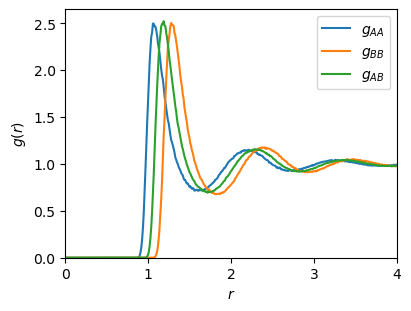

In [29]:
figure = plt.figure(figsize=(4, 3), layout="constrained")
axes = figure.add_subplot(1, 1, 1)

rdf_bins_center = (rdf_bins[:-1] + rdf_bins[1:]) / 2.0
axes.plot(rdf_bins_center, rdf_aa, label="$g_{AA}$")
axes.plot(rdf_bins_center, rdf_bb, label="$g_{BB}$")
axes.plot(rdf_bins_center, rdf_ab, label="$g_{AB}$")

axes.set_xlim(rdf_bins[0], rdf_bins[-1])
axes.set_ylim(0, None)
axes.set_xlabel("$r$")
axes.set_ylabel("$g(r)$")
axes.legend()

plt.show()

### Working Without a Simulation Object

You may notice that the System and all of the Forces we used are members of the `openmm` package, *i.e.*, the library layer of OpenMM, while the Topology and Simulation are still part of the `openmm.app` package, that is, the application layer.  It is actually possible to use the library layer of OpenMM exclusively, never touching `openmm.app` at all.  To do this, once we have our System and Integrator, we can just [create a Context directly](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Context.html#openmm.openmm.Context.__init__):
```python
context = openmm.Context(system, integrator)
```
We then access the Context as `context` rather than `simulation.context`.  In place of [Simulation.step()](https://docs.openmm.org/latest/api-python/generated/openmm.app.simulation.Simulation.html#openmm.app.simulation.Simulation.step), we could use [Integrator.step()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Integrator.html#openmm.openmm.Integrator.step), and in place of [Simulation.minimizeEnergy()](https://docs.openmm.org/latest/api-python/generated/openmm.app.simulation.Simulation.html#openmm.app.simulation.Simulation.minimizeEnergy), we could use OpenMM's [LocalEnergyMinimizer](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.LocalEnergyMinimizer.html).

With this method, it is unnecessary to create a Topology for our System.  However, we lose the ability to use OpenMM's builtin reporters, and also lose some convenience features such as [Simulation.runForClockTime()](https://docs.openmm.org/latest/api-python/generated/openmm.app.simulation.Simulation.html#openmm.app.simulation.Simulation.runForClockTime).  Generally, using the Simulation class from the library layer is most convenient, but you could create and manage Context objects directly if, *e.g.*, you wanted to replace the OpenMM application layer's output reporting system with a completely custom framework for saving simulation results.

### The Completed Script

In case you want to experiment with modifying the Python commands in this tutorial as a standalone Python script rather than as Jupyter notebook cells, they are given all together as follows:

```python
import openmm
import openmm.app
import openmm.unit

import matplotlib.pyplot as plt
import numpy as np

# Define dimensionless units.

length_scale = openmm.unit.nanometer
mass_scale = openmm.unit.dalton
energy_scale = openmm.unit.kilojoule_per_mole
time_scale = openmm.unit.picosecond

press_scale = energy_scale / (length_scale ** 3 * openmm.unit.AVOGADRO_CONSTANT_NA)
temp_scale = energy_scale / (openmm.unit.BOLTZMANN_CONSTANT_kB * openmm.unit.AVOGADRO_CONSTANT_NA)

# Set simulation parameters.

N_A = 500
N_B = 500

rho = 0.6 / length_scale ** 3

m_A = 1.0 * mass_scale
m_B = 1.1 * mass_scale

r_cut = 3.0 * length_scale

sigma_A = 1.0 * length_scale
sigma_B = 1.2 * length_scale

epsilon_A = 1.0 * energy_scale
epsilon_B = 1.3 * energy_scale

press = 2.0 * press_scale
temp = 1.5 * temp_scale
friction = 1.0 / time_scale
step = 0.005 * time_scale

# Create the System.

system = openmm.System()

L_box = ((N_A + N_B) / rho) ** (1 / 3)
system.setDefaultPeriodicBoxVectors(openmm.Vec3(L_box, 0, 0), openmm.Vec3(0, L_box, 0), openmm.Vec3(0, 0, L_box))

for i_A in range(N_A):
    system.addParticle(m_A)
for i_B in range(N_B):
    system.addParticle(m_B)

lj = openmm.NonbondedForce()
lj.setNonbondedMethod(openmm.NonbondedForce.CutoffPeriodic)
lj.setCutoffDistance(r_cut)

for i_A in range(N_A):
    lj.addParticle(0.0, sigma_A, epsilon_A)
for i_B in range(N_B):
    lj.addParticle(0.0, sigma_B, epsilon_B)

system.addForce(lj)

system.addForce(openmm.MonteCarloBarostat(press, temp))

# Create the Integrator.

integrator = openmm.LangevinMiddleIntegrator(temp, friction, step)

# Create the Topology.

topology = openmm.app.Topology()

chain_A = topology.addChain()
chain_B = topology.addChain()

for i_A in range(N_A):
    residue = topology.addResidue("A", chain_A)
    topology.addAtom("A", None, residue)
for i_B in range(N_B):
    residue = topology.addResidue("B", chain_B)
    topology.addAtom("B", None, residue)

# Create the Simulation, and prepare initial positions and velocities.

simulation = openmm.app.Simulation(topology, system, integrator)

grid_a, grid_b = [], []

for i_x in range(10):
    for i_y in range(10):
        for i_z in range(10):
            (grid_a, grid_b)[(i_x + i_y + i_z) % 2].append(openmm.Vec3(i_x / 10, i_y / 10, i_z / 10) * L_box)

simulation.context.setPositions(grid_a + grid_b)
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(temp)

# Run dynamics steps for equilibration.

simulation.step(10000)

# Set up RDF reporting as an example.

# Define the edges of the bins on which to evaluate the RDFs.
rdf_bins = np.linspace(0.0, 4.0, 401)

# Make arrays in which to accumulate the RDFs.
rdf_aa = np.zeros(rdf_bins.size - 1)
rdf_bb = np.zeros(rdf_bins.size - 1)
rdf_ab = np.zeros(rdf_bins.size - 1)

# Track the number of accumulations we have done so far.
rdf_count = 0

def calculate_rdf(state):
    global rdf_aa, rdf_bb, rdf_ab, rdf_count

    # Extract the positions and box vectors from a State.
    positions = state.getPositions(asNumpy=True) / length_scale
    lengths = np.diag(state.getPeriodicBoxVectors() / length_scale)

    # Apply the minimum image convention.  WARNING: This implementation ONLY works for orthorhombic periodic boxes!
    # MonteCarloBarostat will not deform the periodic box, and it starts as a cube, so it works for this case.
    dr_ij = positions[:, None] - positions[None, :]
    dr_ij -= np.round(dr_ij / lengths) * lengths
    r_ij = np.sqrt(np.sum(dr_ij * dr_ij, axis=-1))

    # Get the distances between A-A, B-B, and A-B pairs.
    r_aa = r_ij[:N_A, :N_A][np.triu_indices(N_A, 1)]
    r_bb = r_ij[N_A:, N_A:][np.triu_indices(N_B, 1)]
    r_ab = r_ij[:N_A, N_A:].flatten()

    # Accumulate the RDFs.
    rdf_aa += np.prod(lengths) * np.histogram(r_aa, bins=rdf_bins, weights=1.0 / (r_aa * r_aa))[0] / r_aa.size
    rdf_bb += np.prod(lengths) * np.histogram(r_bb, bins=rdf_bins, weights=1.0 / (r_bb * r_bb))[0] / r_bb.size
    rdf_ab += np.prod(lengths) * np.histogram(r_ab, bins=rdf_bins, weights=1.0 / (r_ab * r_ab))[0] / r_ab.size
    rdf_count += 1

# Run dynamics steps for production.

for i in range(1000):
    simulation.step(100)
    calculate_rdf(simulation.context.getState(positions=True))

# Average and normalize the RDFs.

rdf_scale = 1.0 / (4.0 * np.pi * rdf_count * (rdf_bins[1:] - rdf_bins[:-1]))
rdf_aa *= rdf_scale
rdf_bb *= rdf_scale
rdf_ab *= rdf_scale

# Plot the results.

figure = plt.figure(figsize=(4, 3), layout="constrained")
axes = figure.add_subplot(1, 1, 1)

rdf_bins_center = (rdf_bins[:-1] + rdf_bins[1:]) / 2.0
axes.plot(rdf_bins_center, rdf_aa, label="$g_{AA}$")
axes.plot(rdf_bins_center, rdf_bb, label="$g_{BB}$")
axes.plot(rdf_bins_center, rdf_ab, label="$g_{AB}$")

axes.set_xlim(rdf_bins[0], rdf_bins[-1])
axes.set_ylim(0, None)
axes.set_xlabel("$r$")
axes.set_ylabel("$g(r)$")
axes.legend()

plt.show()
```

## Summary and Further Reading

After following this tutorial, you should be able to:
* Build an OpenMM System from scratch for a Lennard-Jones fluid mixture
* Build a Topology from scratch and use it with a System to create a Simulation
* Work with dimensionless units in OpenMM

This tutorial only covered the basics of setting up a System from scratch in OpenMM.  OpenMM's library layer comes with a [large number of Forces](https://docs.openmm.org/latest/api-python/library.html#forces) implementing all kinds of bonded and non-bonded interactions.  OpenMM provides standard interactions found in many classical molecular mechanics force fields, such as [HarmonicBondForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.HarmonicBondForce.html) and [PeriodicTorsionForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.PeriodicTorsionForce.html).  However, it also provides a large number of *custom forces*, which allow you to define interactions from arbitrary expressions.  This flexibility enables you to use many kinds of potential functions in OpenMM without needing to write any additional C++ or even Python code.  The theory section of the user guide details most of the [standard](https://docs.openmm.org/latest/userguide/theory/02_standard_forces.html) and [custom](https://docs.openmm.org/latest/userguide/theory/03_custom_forces.html) forces listed in the API documentation.

These introductory tutorials have now covered the basics of using OpenMM to load and parameterize existing molecular structures, read input files for other molecular dynamics engines, and build custom molecular systems from the ground up.  From here, you should be equipped to understand the details of the [more advanced tutorials](../../tutorials.rst#beyond-the-basics), which describe how to set up specific kinds of simulations or implement specific methods with OpenMM.  Unlike this introductory series, designed to be followed in order, the other tutorials are mostly standalone units: when this is not the case, links will be provided to any prerequisites.  You may also want to consult the [OpenMM Cookbook](../../cookbook.rst) for shorter examples of how to accomplish particular tasks in OpenMM.

## Links

* Relevant sections of the [User Guide](https://docs.openmm.org/latest/api-python/):
  * [Units and dimensional analysis](https://docs.openmm.org/latest/userguide/library/05_languages_not_cpp.html#units-and-dimensional-analysis) in the Python API
  * [Units](https://docs.openmm.org/latest/userguide/theory/01_introduction.html#units) and [physical constants](https://docs.openmm.org/latest/userguide/theory/01_introduction.html#physical-constants) used by default in OpenMM
  * Theory behind [Standard Forces](https://docs.openmm.org/latest/userguide/theory/02_standard_forces.html)
  * Theory behind [Custom Forces](https://docs.openmm.org/latest/userguide/theory/03_custom_forces.html)
* [Python API documentation](https://docs.openmm.org/latest/api-python/) pages for:
  * Common standard forces (not exhaustive):
    * [HarmonicBondForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.HarmonicBondForce.html)
    * [HarmonicAngleForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.HarmonicAngleForce.html)
    * [PeriodicTorsionForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.PeriodicTorsionForce.html)
    * [CMAPTorsionForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CMAPTorsionForce.html)
    * [NonbondedForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.NonbondedForce.html)
  * Common custom forces (not exhaustive):
    * [CustomBondForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomBondForce.html)
    * [CustomAngleForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomAngleForce.html)
    * [CustomTorsionForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomTorsionForce.html)
    * [CustomExternalForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomExternalForce.html)
    * [CustomCompoundBondForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomCompoundBondForce.html)
    * [CustomNonbondedForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomNonbondedForce.html)
    * [CustomManyParticleForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomManyParticleForce.html)